# Data Understanding

In [ ]:
pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.7 MB/s eta 0:00:00


## Import and Load Dataset

Dataset yang digunakan dalam proyek ini merupakan dataset harga saham harian Tesla yang mencakup periode tertentu dari periode 06/29/2010 hingga 03/17/2017 yang terdiri dari 7 kolom dengan 1692 baris data. Dataset ini diperoleh dari Kaggle melalui tautan berikut: https://www.kaggle.com/datasets/rpaguirre/tesla-stock-price/data


* Date - Tanggal pencatatan harga saham.
* Open - Harga saham pada awal perdagangan.
* High - Harga tertinggi yang dicapai dalam satu hari perdagangan.
* Low - Harga terendah dalam satu hari perdagangan.
* Close - Harga penutupan saham pada akhir perdagangan.
* Adj Close - Harga penutupan yang disesuaikan.
* Volume - Jumlah saham yang diperdagangkan dalam satu hari.
















In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import random


# Set seed untuk memastikan hasil yang konsisten
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Load data
df = pd.read_csv('/content/Tesla.csv - Tesla.csv.csv', index_col='Date', parse_dates=True)
#df = df.drop['Adj close']
df

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
...,...,...,...,...,...,...
2017-03-13,244.820007,246.850006,242.779999,246.169998,3010700,246.169998
2017-03-14,246.110001,258.119995,246.020004,258.000000,7575500,258.000000
2017-03-15,257.000000,261.000000,254.270004,255.729996,4816600,255.729996


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

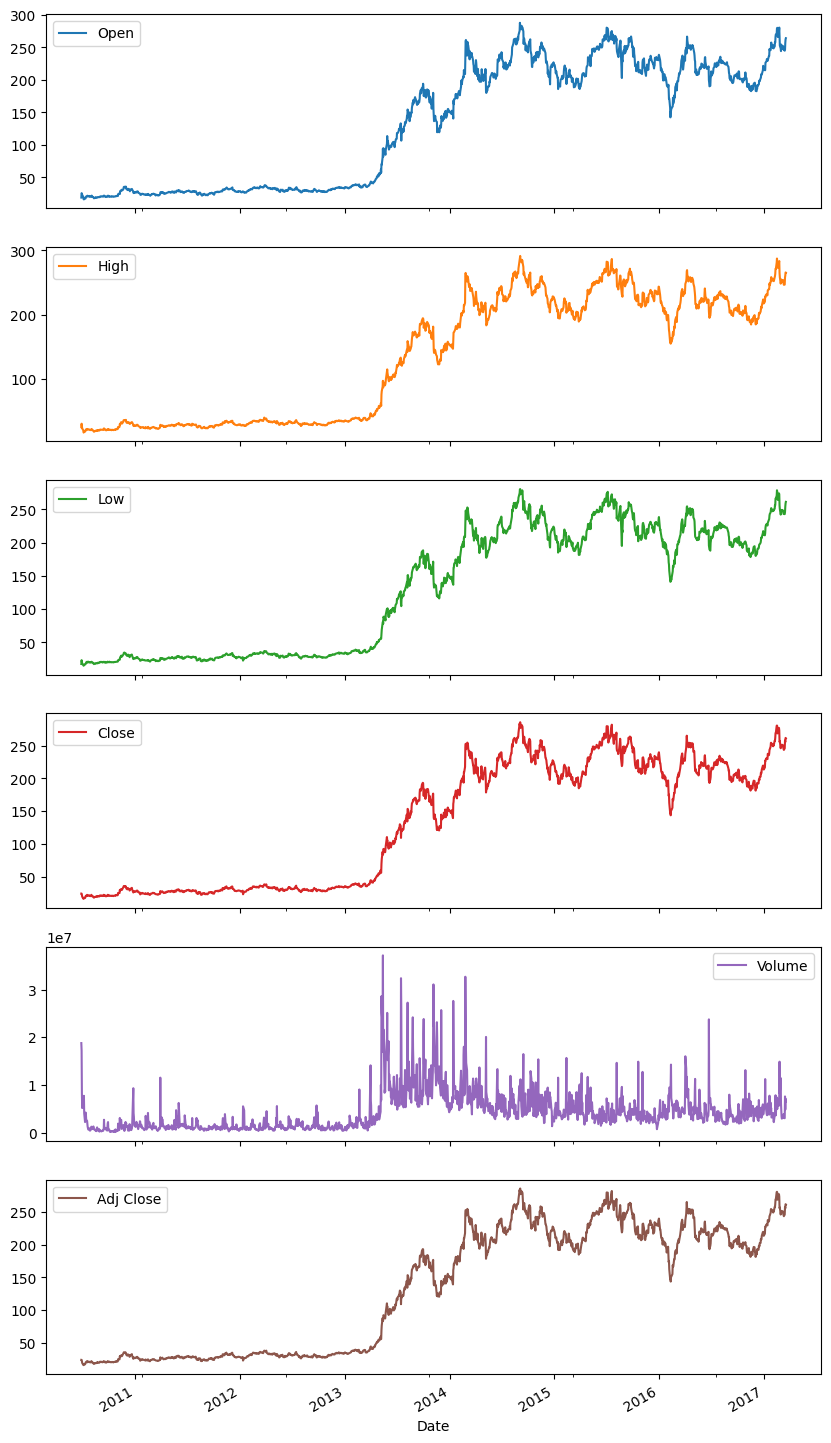

In [ ]:
df.plot(subplots=True,figsize=(10,20))

Kondisi Data:

* Semua variabel berbentuk numerik dengan tipe data float64 (Open, High, Low, Close, Adj Close) dan int64 (Volume).
* Missing Value: Tidak ditemukan nilai yang hilang karena semua kolom memiliki 1692 non-null count.
* Duplikasi: Tidak ada indikasi duplikasi berdasarkan informasi yang diberikan.




In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1692 entries, 2010-06-29 to 2017-03-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1692 non-null   float64
 1   High       1692 non-null   float64
 2   Low        1692 non-null   float64
 3   Close      1692 non-null   float64
 4   Volume     1692 non-null   int64  
 5   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 92.5 KB


Berdasarkan statistik deskriptif, terdapat kemungkinan outlier pada kolom Volume, di mana nilai maksimum (37,163,900) jauh lebih besar dibandingkan kuartil ketiga (5,662,100). Oleh karena itu, pada tahap selanjutnya akan dilakukan pengecekan outliers




In [ ]:
df.describe()


,Open,High,Low,Close,Volume,Adj Close
count,1692.000000,1692.000000,1692.000000,1692.000000,1.692000e+03,1692.000000
mean,132.441572,134.769698,129.996223,132.428658,4.270741e+06,132.428658
std,94.309923,95.694914,92.855227,94.313187,4.295971e+06,94.313187
min,16.139999,16.629999,14.980000,15.800000,1.185000e+05,15.800000
25%,30.000000,30.650000,29.215000,29.884999,1.194350e+06,29.884999
50%,156.334999,162.370002,153.150002,158.160004,3.180700e+06,158.160004
75%,220.557495,224.099999,217.119999,220.022503,5.662100e+06,220.022503
max,287.670013,291.420013,280.399994,286.040009,3.716390e+07,286.040009


Korelasi:

* Variabel Fitur Open, High, Low, memiliki korelasi yang sangat tinggi (mendekati 1), terhadap variabel target yaitu Close sehingga menunjukkan hubungan linear kuat..

* Fitur Volume memiliki korelasi rendah dengan harga saham (~0.40), yang menunjukkan bahwa perubahan harga tidak selalu berkaitan dengan jumlah volume perdagangan.


In [ ]:
df.corr()

,Open,High,Low,Close,Volume,Adj Close
Open,1.000000,0.999623,0.999605,0.999233,0.407515,0.999233
High,0.999623,1.000000,0.999521,0.999691,0.416466,0.999691
Low,0.999605,0.999521,1.000000,0.999656,0.397615,0.999656
Close,0.999233,0.999691,0.999656,1.000000,0.406907,1.000000
Volume,0.407515,0.416466,0.397615,0.406907,1.000000,0.406907
Adj Close,0.999233,0.999691,0.999656,1.000000,0.406907,1.000000


## Deteksi Outlier

Berdasarkan visualisasi boxplot, terdapat outlier pada variabel Volume. Oleh karena itu, akan dilakukan pengecekan outlier tersebut. Kemudian, berikutnya outlier tersebut akan dihapus / didrop karena jumlahnya tidak begitu banyak sehingga tidak berpengaruh signifikan terhadap dataset yang ada

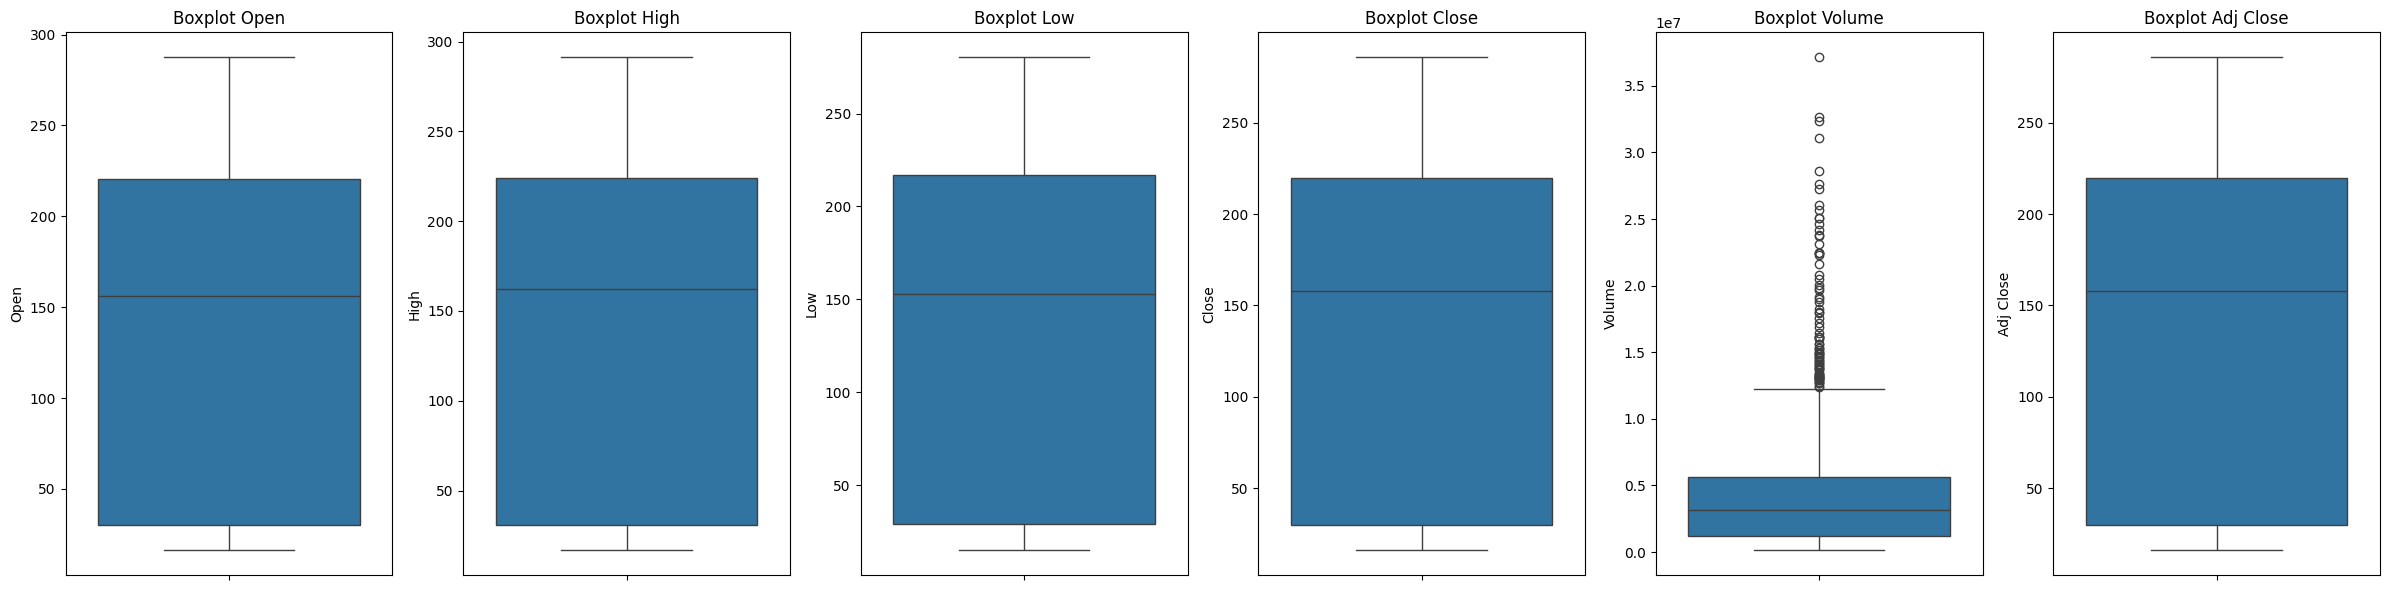

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur ukuran figure
plt.figure(figsize=(len(df.columns) * 4, 6))

# Loop untuk membuat boxplot vertikal untuk setiap kolom
for i, col in enumerate(df.columns, 1):
    plt.subplot(1, len(df.columns), i)  # Membuat subplot secara horizontal
    sns.boxplot(y=df[col])  # Boxplot vertikal
    plt.title(f"Boxplot {col}")

plt.tight_layout()  # Mengatur tata letak agar tidak bertumpuk
plt.show()



## Hapus Outlier

Penghapusan outliers dilakukan menggunakan metode IQR. Outlier berjumlah 80. Setelah dilakukan penghapusan baris data yang mengandung outliers, sehingga dihasilkan data bersih terdiri dari 1612 baris data dari sebelumnya berjumlah 1692 baris.

In [ ]:
import numpy as np
import pandas as pd

# Menghitung Q1 (Kuartil 25%) dan Q3 (Kuartil 75%)
Q1 = df['Volume'].quantile(0.25)
Q3 = df['Volume'].quantile(0.75)

# Menghitung IQR
IQR = Q3 - Q1

# Menentukan batas bawah dan batas atas untuk outlier
batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

#  Menghitung jumlah outlier
jumlah_outlier = ((df['Volume'] < batas_bawah) | (df['Volume'] > batas_atas)).sum()
print(f"Jumlah Outlier pada 'Volume': {jumlah_outlier}")

# **2. Menampilkan outlier**
outliers = df[(df['Volume'] < batas_bawah) | (df['Volume'] > batas_atas)]
print("\nOutlier pada 'Volume':")
print(outliers)

# **3. Menghapus outlier**
df_cleaned = df[(df['Volume'] >= batas_bawah) & (df['Volume'] <= batas_atas)]

print(f"\nJumlah data setelah menghapus outlier: {len(df_cleaned)} (Sebelumnya: {len(df)})")


Jumlah Outlier pada 'Volume': 80

Outlier pada 'Volume':
                  Open        High         Low       Close    Volume  \
Date                                                                   
2010-06-29   19.000000   25.000000   17.540001   23.889999  18766300   
2010-06-30   25.790001   30.420000   23.299999   23.830000  17187100   
2013-04-01   42.360001   46.680000   41.700001   43.930000  14098500   
2013-05-09   70.120003   75.769997   63.689999   69.400002  28605000   
2013-05-10   69.650002   81.000000   69.250000   76.760002  25082600   
...                ...         ...         ...         ...       ...   
2016-04-01  244.830002  247.899994  233.250000  237.589996  15997500   
2016-04-04  249.119995  252.119995  243.639999  246.990005  13475300   
2016-06-22  199.470001  205.949997  195.750000  196.660004  23742400   
2016-10-27  211.339996  213.699997  201.649994  204.009995  13093700   
2017-02-23  264.000000  264.660004  255.559998  255.990005  14867000   

      

# Data Preparation

# Pembagian Data Latih dan Uji

Pada tahap ini dilakukan pembagian data menjadi menjadi dua bagian yaitu data latih dan data uji. Pembagian data latih dan data uji ini menggunakan skenario 80:20. Variabel fitur terdiri dari kolom Open, High, Low, dan Volume, sedangkan variabel targetnya yaitu Close.

In [ ]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Partisi data dengan train_test_split (tanpa shuffle, cocok untuk time series)
test_prop = 0.2
train_df, test_df = train_test_split(df_cleaned, test_size=test_prop, shuffle=False)


# Penentuan variabel X dan Y
train_features = train_df[['Open', 'High', 'Low', 'Volume']]
train_target = train_df[['Close']]

test_features = test_df[['Open', 'High', 'Low', 'Volume']]
test_target = test_df[['Close']]  # Target 'Close'

In [ ]:
train_features

,Open,High,Low,Volume
Date,,,,
2010-07-01,25.000000,25.920000,20.270000,8218800
2010-07-02,23.000000,23.100000,18.709999,5139800
2010-07-06,20.000000,20.000000,15.830000,6866900
2010-07-07,16.400000,16.629999,14.980000,6921700
2010-07-08,16.139999,17.520000,15.570000,7711400
...,...,...,...,...
2015-11-18,214.500000,221.380005,212.520004,2811900
2015-11-19,220.539993,226.190002,220.300003,2504400
2015-11-20,223.490005,225.000000,213.580002,4400700


In [ ]:
train_target

,Close
Date,
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
2010-07-07,15.800000
2010-07-08,17.459999
...,...
2015-11-18,221.070007
2015-11-19,221.800003
2015-11-20,220.009995


In [ ]:
print("train fitur:", train_features.shape)
print("train target:", train_target.shape)
print("test fitur:", test_features.shape)
print("test target:", test_target.shape)


train fitur: (1289, 4)
train target: (1289, 1)
test fitur: (323, 4)
test target: (323, 1)


## Normalisasi

Pada tahap ini dilakukan normalisasi data dengan mengubah nilai-nilai dari suatu dataset ke dalam rentang nilai tertentu. Pada proyek ini normalisasi dilakukan menggunakan Metode Min Max sehingga diubah menjadi rentang 0 sampai 1. Tujuan utama normalisasi adalah untuk menghasilkan data yang konsisten sehingga setiap variabel memiliki pangaruh yang seimbang terhadap model yang dibangun

In [ ]:

# Normalisasi setiap fitur satu per satu di data pelatihan
scalers = {}
train_features_scaled = []

for feature in train_features.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_feature = scaler.fit_transform(train_features[[feature]])
    scalers[feature] = scaler  # Simpan scaler untuk fitur ini
    train_features_scaled.append(scaled_feature)

# Gabungkan kembali fitur yang dinormalisasi
train_features_scaled = np.hstack(train_features_scaled)

# Normalisasi target secara terpisah
scaler_target = MinMaxScaler(feature_range=(0, 1))
train_target_scaled = scaler_target.fit_transform(train_target)


## Pembuatan Urutan Data Baru

Setelah melakukan normalisasi data, tahap berikutnya adalah pembuatan urutan data baru menjadi ukuran 3 dimensi (samples, timesteps, jumlah fitur) agar sesuai dengan input yang diperlukan oleh model biLSTM. Timesteps digunakan untuk menentukan jumlah data masa lalu yang diperhitungkan dalam memprediksi satu nilai di masa depan. Pada tahap ini timesteps yang digunakan adalah 9 sehingga setiap prediksi di masa depan mempertimbangkan 9data di masa lalu.

In [ ]:

# variabel penyimpan nilai timestep
timesteps = 9

# Penyesuaian struktur data pelatihan (multivariate forecasting)
train_data = np.hstack((train_features_scaled, train_target_scaled))
x_train = []
y_train = []
for i in range(timesteps, len(train_data)):
    x_train.append(train_data[i-timesteps:i, :-1])  # Mengambil semua fitur kecuali target
    y_train.append(train_data[i, -1])  # Target: 'AI'

# Mengonversi list ke numpy array setelah loop
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape data untuk input LSTM [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], train_features_scaled.shape[1]))  # Jumlah fitur input
y_train = y_train.reshape((y_train.shape[0], 1))  # Target tetap 1D

# Normalisasi setiap fitur satu per satu di data pengujian menggunakan scaler yang telah di-fit dari data pelatihan
test_features_scaled = []

for feature in test_features.columns:
    scaled_feature = scalers[feature].transform(test_features[[feature]])
    test_features_scaled.append(scaled_feature)

# Gabungkan kembali fitur yang dinormalisasi untuk data pengujian
test_features_scaled = np.hstack(test_features_scaled)

# Normalisasi target pengujian secara terpisah
test_target_scaled = scaler_target.transform(test_target)

# Penyesuaian struktur data pengujian
test_data = np.hstack((test_features_scaled, test_target_scaled))
x_test = []
y_test = []
for i in range(timesteps, len(test_data)):
    x_test.append(test_data[i-timesteps:i, :-1])  # Mengambil semua fitur kecuali target
    y_test.append(test_data[i, -1])  # Target: 'AI'

# Mengonversi list ke numpy array setelah loop
x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape data untuk input LSTM [samples, timesteps, features]
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], test_features_scaled.shape[1]))  # Jumlah fitur input
y_test = y_test.reshape((y_test.shape[0], 1))  # Target tetap 1D


In [ ]:
train_features_scaled

array([[0.03262991, 0.03380764, 0.01993068, 0.66909791],
       [0.02526425, 0.02354526, 0.0140532 , 0.41476752],
       [0.01421574, 0.01226391, 0.00320247, 0.55742878],
       ...,
       [0.76363568, 0.75828811, 0.74824808, 0.35371666],
       [0.74102308, 0.73710828, 0.75239243, 0.19887992],
       [0.73373103, 0.74373154, 0.75359809, 0.19508851]])

In [ ]:
np.set_printoptions(threshold=10)  # threshold menentukan berapa banyak elemen yang ditampilkan

(train_target_scaled)

array([[0.02279455],
       [0.01258141],
       [0.00114713],
       ...,
       [0.75566159],
       [0.74729867],
       [0.74914888]])

Pada Gambar di bawah ini ditunjukkan bahwa ukuran data latih dan data uji sudah berubah menjadi ukuran 3 dimensi.

In [ ]:
print("Urutan data baru train fitur:", x_train.shape)
print("Urutan data baru train target:", y_train.shape)
print("Urutan data baru test fitur:", x_test.shape)
print("Urutan data baru test target:", y_test.shape)

Urutan data baru train fitur: (1280, 9, 4)
Urutan data baru train target: (1280, 1)
Urutan data baru test fitur: (314, 9, 4)
Urutan data baru test target: (314, 1)


# Modeling Bidirectional LSTM

Parameter terbaik yang diperoleh dari hasil tuning untuk model BiLSTM adalah sebagai berikut:
*   lstm_units: 50
*   dropout: 0.1
*   optimizer: adam

Setelah mendapatkan parameter terbaik dari hasil tuning, model final kemudian dibangun dan dilatih menggunakan parameter tersebut.

In [ ]:
import keras_tuner as kt
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.models import Sequential
from keras.regularizers import l2
import tensorflow as tf

# Fungsi untuk membuat model LSTM dengan parameter yang bisa dituning
def build_model(hp):
    model = Sequential()

    # Layer LSTM pertama
    model.add(Bidirectional(LSTM(hp.Choice('lstm_units', [50, 100]),
                                 activation='tanh', return_sequences=True,
                                 kernel_regularizer=l2(1e-5)),
                            input_shape=(x_train.shape[1], x_train.shape[2])))

    # Dropout layer
    model.add(Dropout(hp.Choice('dropout', [0.1, 0.2, 0.3])))

    # Layer LSTM kedua
    model.add(Bidirectional(LSTM(hp.Choice('lstm_units', [50, 100]),
                                 activation='tanh', kernel_regularizer=l2(1e-5))))

    # Dense layer
    model.add(Dense(1, kernel_regularizer=l2(1e-5)))

    # Compile model dengan loss function MSE
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  loss='mean_squared_error')

    return model

# Inisialisasi tuner Hyperband
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=50,
                     factor=3,
                     directory='hyperband_tuning',
                     project_name='LSTM_Tuning_Limited')

# Early stopping untuk menghentikan training jika tidak ada peningkatan
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Menjalankan tuning
tuner.search(x_train, y_train, epochs=50, validation_split=0.1, batch_size=64, callbacks=[early_stopping])

# Mendapatkan parameter terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Menampilkan parameter terbaik
print(f"""
Parameter terbaik yang ditemukan:
- lstm_units: {best_hps.get('lstm_units')}
- dropout: {best_hps.get('dropout')}
- optimizer: {best_hps.get('optimizer')}
""")

# Membuat model dengan parameter terbaik
best_model = tuner.hypermodel.build(best_hps)

# Melatih model dengan parameter terbaik
history = best_model.fit(x_train, y_train, epochs=50, validation_split=0.1, batch_size=64, callbacks=[early_stopping])

# Menampilkan loss terakhir
LastLoss = '%.4f' % history.history['val_loss'][-1]
print(f"Loss Terakhir dengan Parameter Terbaik: {LastLoss}")


Trial 10 Complete [00h 00m 12s]
val_loss: 0.007957903668284416

Best val_loss So Far: 0.004241796210408211
Total elapsed time: 00h 01m 52s

Parameter terbaik yang ditemukan:
- lstm_units: 50
- dropout: 0.1
- optimizer: adam

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 0.0888 - val_loss: 0.0433
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0100 - val_loss: 0.0065
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 10/5

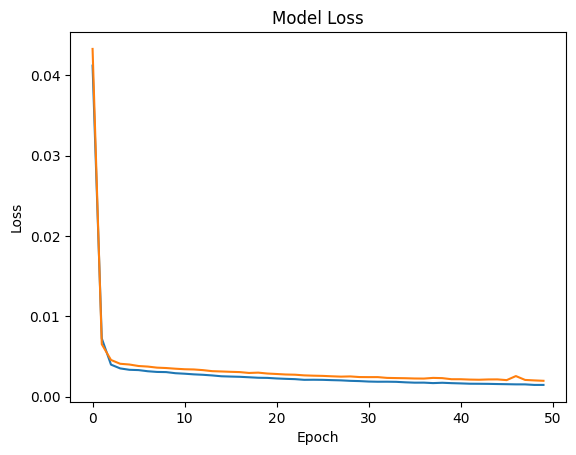

In [ ]:

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Prediksi Data Tes

In [ ]:
# Prediksi menggunakan data pengujian
y_test_pred = best_model.predict(x_test)

# Denormalisasi hasil prediksi
y_test_pred = scaler_target.inverse_transform(y_test_pred)

y_test_pred[y_test_pred < 0] = 0
print(y_test_pred)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
[[232.35359]
 [230.81447]
 [229.76585]
 ...
 [246.17578]
 [249.07951]
 [251.8559 ]]


<Figure size 1000x600 with 0 Axes>

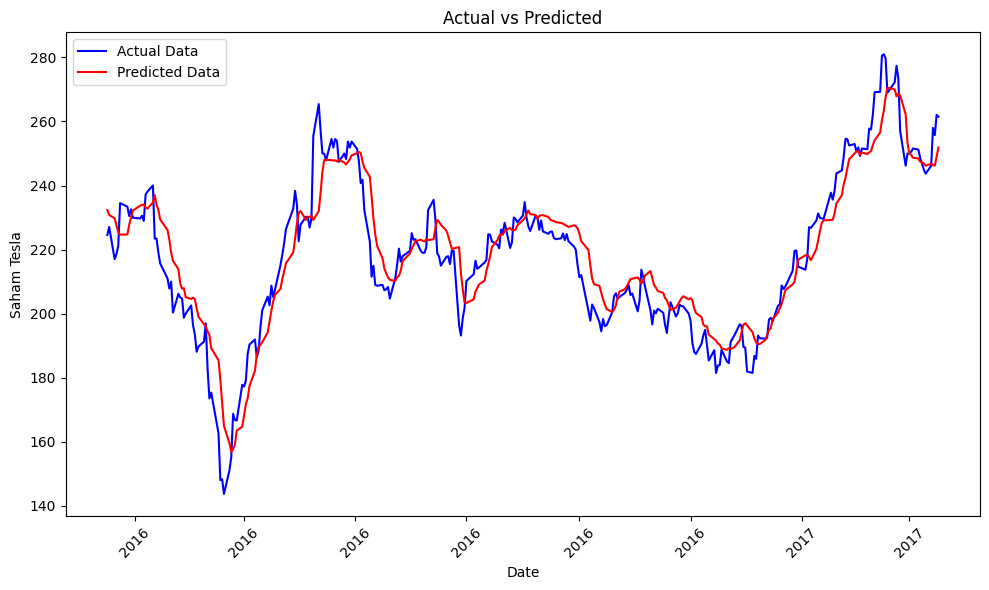

In [ ]:
import matplotlib.pyplot as plt

# Denormalisasi target asli untuk data pengujian
y_test_denorm = scaler_target.inverse_transform(y_test)

# Plot hasil prediksi vs data aktual
plt.figure(figsize=(10, 6))

# Plot data aktual
y_test_denorm_series = pd.Series(y_test_denorm.ravel(), index=df.index[-len(y_test_denorm):])
y_test_pred_series = pd.Series(y_test_pred.ravel(), index=df.index[-len(y_test_pred):])


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test_denorm_series, label='Actual Data', color='blue')
plt.plot(y_test_pred_series, label='Predicted Data', color='red')


# Judul, label, dan pengaturan sumbu X
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Saham Tesla')
plt.legend()
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Pastikan y_test_denorm dan y_test_pred sudah terdefinisi
# Menghitung Mean Squared Error (MSE)
mseLSTM = mean_squared_error(y_test_denorm, y_test_pred)

# Menghitung R-squared (R²)
r_squaredLSTM = r2_score(y_test_denorm, y_test_pred)

# Menghitung Mean Absolute Percentage Error (MAPE)
epsilon = 1e-10  # Untuk menghindari pembagian dengan nol
mapeLSTM = 100 * np.mean(np.abs((y_test_denorm - y_test_pred) / (y_test_denorm + epsilon)))

# Menghitung Mean Absolute Error (MAE)
maeLSTM = mean_absolute_error(y_test_denorm, y_test_pred)

# Menampilkan hasil evaluasi
print('Test MSE: %.4f' % mseLSTM)
print('R-squared: %.4f' % r_squaredLSTM)
print('MAPE: %.2f' % mapeLSTM)
print('MAE: %.2f' % maeLSTM)


Test MSE: 76.1575
R-squared: 0.8777
MAPE: 3.20
MAE: 6.75


# Forecast Masa Depan (30 hari)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

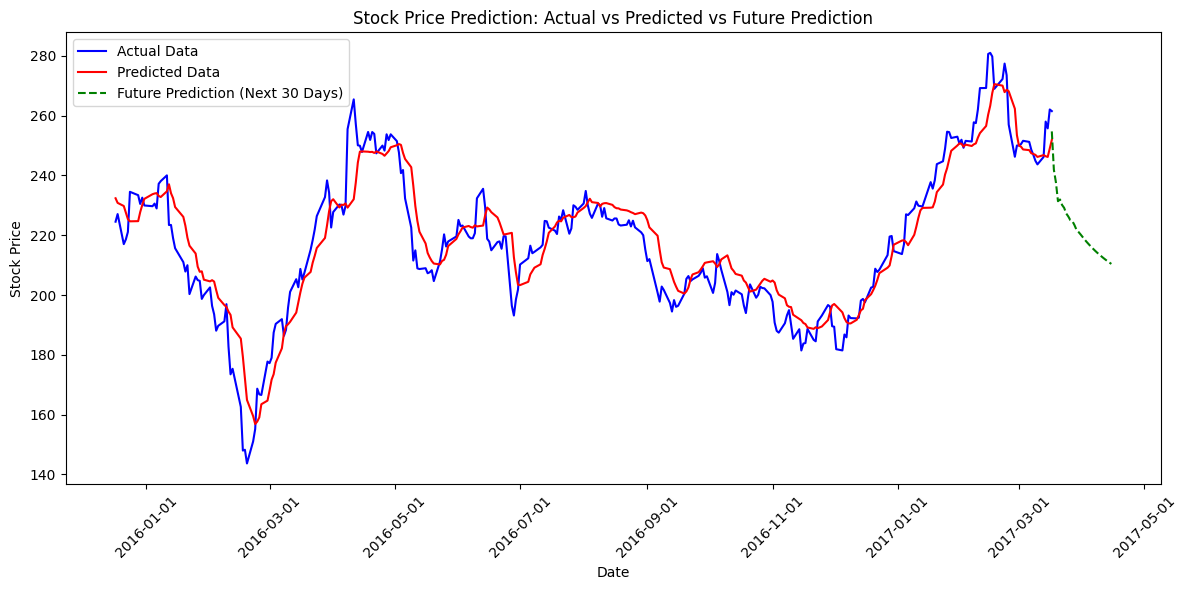

In [ ]:

# *Prediksi Masa Depan 30 Hari dengan Timestep 9*


# Gunakan data terakhir dari dataset pengujian sebagai input awal (timestep = 9)
future_input = test_data[-timesteps:, :-1]  # Ambil 9 timestep terakhir sebagai input awal
future_predictions = []

# Loop untuk memprediksi 180 hari ke depan
for _ in range(30):
    # Prediksi hari berikutnya berdasarkan 9 timestep terakhir
    pred = best_model.predict(future_input.reshape(1, timesteps, -1))

    # Simpan hasil prediksi
    future_predictions.append(pred[0, 0])  # Ambil nilai pertama hasil prediksi

    # Perbarui future_input dengan menggantikan data lama
    new_row = np.hstack((future_input[-1, 1:], pred[0]))
    future_input = np.vstack((future_input[1:], new_row))

# Denormalisasi hasil prediksi masa depan
future_predictions = scaler_target.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Buat index tanggal baru untuk prediksi masa depan
last_date = df.index[-1]  # Ambil tanggal terakhir dari dataset
future_dates = pd.date_range(start=last_date, periods=30, freq='D')  # Buat rentang 180 hari ke depan

# Konversi prediksi masa depan ke pandas Series
future_pred_series = pd.Series(future_predictions.ravel(), index=future_dates)

# -------------------------
# **Plot Data Aktual, Prediksi, dan Prediksi Masa Depan**
# -------------------------
plt.figure(figsize=(12, 6))

# Plot data aktual
plt.plot(y_test_denorm_series, label='Actual Data', color='blue')

# Plot hasil prediksi pada data uji
plt.plot(y_test_pred_series, label='Predicted Data', color='red')

# Plot prediksi masa depan
plt.plot(future_pred_series, label='Future Prediction (Next 30 Days)', color='green', linestyle='dashed')

# Judul dan label
plt.title('Stock Price Prediction: Actual vs Predicted vs Future Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)

# Format tanggal agar lebih rapi
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.show()


In [ ]:
from tabulate import tabulate

# Format ulang tanggal agar hanya menampilkan "YYYY-MM-DD"
formatted_dates = [date.strftime('%Y-%m-%d') for date in future_dates]

# Buat daftar tanggal prediksi dan nilai prediksi
data = list(zip(formatted_dates, future_predictions.ravel()))

# Buat header tabel
headers = ['Date', 'Prediction']

# Buat tabel dengan format yang lebih rapi
table = tabulate(data, headers=headers, tablefmt='fancy_grid')

# Cetak tabel
print(table)



╒════════════╤══════════════╕
│ Date       │   Prediction │
╞════════════╪══════════════╡
│ 2017-03-17 │      254.713 │
├────────────┼──────────────┤
│ 2017-03-18 │      241.898 │
├────────────┼──────────────┤
│ 2017-03-19 │      237.657 │
├────────────┼──────────────┤
│ 2017-03-20 │      231.373 │
├────────────┼──────────────┤
│ 2017-03-21 │      231.937 │
├────────────┼──────────────┤
│ 2017-03-22 │      230.108 │
├────────────┼──────────────┤
│ 2017-03-23 │      229.149 │
├────────────┼──────────────┤
│ 2017-03-24 │      227.28  │
├────────────┼──────────────┤
│ 2017-03-25 │      226.297 │
├────────────┼──────────────┤
│ 2017-03-26 │      225.048 │
├────────────┼──────────────┤
│ 2017-03-27 │      224.734 │
├────────────┼──────────────┤
│ 2017-03-28 │      223.429 │
├────────────┼──────────────┤
│ 2017-03-29 │      221.846 │
├────────────┼──────────────┤
│ 2017-03-30 │      221.087 │
├────────────┼──────────────┤
│ 2017-03-31 │      220.271 │
├────────────┼──────────────┤
│ 2017-04-

# Model Bidirectional GRU

Parameter terbaik yang diperoleh dari hasil tuning untuk model BiGRU adalah sebagai berikut:
*   gru_units: 50
*   dropout: 0.3
*   optimizer: rmsprop

Setelah mendapatkan parameter terbaik dari hasil tuning, model final kemudian dibangun dan dilatih menggunakan parameter tersebut.

In [ ]:
import keras_tuner as kt
from keras.layers import GRU, Dense, Dropout, Bidirectional
from keras.models import Sequential
from keras.regularizers import l2
import tensorflow as tf

# Fungsi untuk membuat model GRU dengan parameter yang bisa dituning
def build_model(hp):
    model = Sequential()

    # Layer GRU pertama
    model.add(Bidirectional(GRU(hp.Int('gru_units', min_value=50, max_value=100, step=50),
                                activation='tanh', return_sequences=True,
                                kernel_regularizer=l2(1e-5)),
                             input_shape=(x_train.shape[1], x_train.shape[2])))

    # Dropout layer
    model.add(Dropout(hp.Choice('dropout', [0.1, 0.2, 0.3])))

    # Layer GRU kedua
    model.add(Bidirectional(GRU(hp.Int('gru_units', min_value=50, max_value=100, step=50),
                                activation='tanh', kernel_regularizer=l2(1e-5))))

    # Dense layer
    model.add(Dense(1, kernel_regularizer=l2(1e-5)))

    # Compile model dengan loss function MSE
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  loss='mean_squared_error')

    return model

# Inisialisasi tuner Hyperband
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=50,
                     factor=3,
                     directory='hyperband_tuning',
                     project_name='GRU_Tuning')

# Early stopping untuk menghentikan training jika tidak ada peningkatan
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Menjalankan tuning
tuner.search(x_train, y_train, epochs=50, validation_split=0.1, batch_size=64, callbacks=[early_stopping])

# Mendapatkan parameter terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Menampilkan parameter terbaik
print(f"""
Parameter terbaik yang ditemukan:
- gru_units: {best_hps.get('gru_units')}
- dropout: {best_hps.get('dropout')}
- optimizer: {best_hps.get('optimizer')}
""")

# Membuat model dengan parameter terbaik
best_model = tuner.hypermodel.build(best_hps)

# Melatih model dengan parameter terbaik
history = best_model.fit(x_train, y_train, epochs=50, validation_split=0.1, batch_size=64, callbacks=[early_stopping])

# Menampilkan loss terakhir
LastLoss = '%.4f' % history.history['val_loss'][-1]
print(f"Loss Terakhir dengan Parameter Terbaik: {LastLoss}")


Trial 11 Complete [00h 00m 11s]
val_loss: 0.006386931054294109

Best val_loss So Far: 0.003844381310045719
Total elapsed time: 00h 02m 04s

Parameter terbaik yang ditemukan:
- gru_units: 50
- dropout: 0.3
- optimizer: rmsprop

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.0642 - val_loss: 0.0045
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0068 - val_loss: 0.0185
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0079 - val_loss: 0.0190
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0054 - val_loss: 0.0080
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0053 - val_loss: 0.0181
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0062 - val_loss: 0.0241
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0063 - val_loss: 0.0039
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0046 - val_loss: 0.0079
Epoch 10

## Prediksi Pada Data Tes Model Bidirectional GRU

In [ ]:
# Prediksi menggunakan data pengujian
y_test_pred = best_model.predict(x_test)

# Denormalisasi hasil prediksi
y_test_pred = scaler_target.inverse_transform(y_test_pred)

y_test_pred[y_test_pred < 0] = 0
print(y_test_pred)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
[[229.2025 ]
 [228.19101]
 [227.32005]
 ...
 [246.25183]
 [249.37193]
 [252.92982]]


## Evaluasi Model BIGRU

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Pastikan y_test_denorm dan y_test_pred sudah terdefinisi
# Menghitung Mean Squared Error (MSE)
mseGRU = mean_squared_error(y_test_denorm, y_test_pred)

# Menghitung R-squared (R²)
r_squaredGRU = r2_score(y_test_denorm, y_test_pred)

# Menghitung Mean Absolute Percentage Error (MAPE)
epsilon = 1e-10  # Untuk menghindari pembagian dengan nol
mapeGRU = 100 * np.mean(np.abs((y_test_denorm - y_test_pred) / (y_test_denorm + epsilon)))

# Menghitung Mean Absolute Error (MAE)
maeGRU = mean_absolute_error(y_test_denorm, y_test_pred)

# Menampilkan hasil evaluasi
print('Test MSE: %.4f' % mseGRU)
print('R-squared: %.4f' % r_squaredGRU)
print('MAPE: %.2f' % mapeGRU)
print('MAE: %.2f' % maeGRU)


Test MSE: 69.4211
R-squared: 0.8885
MAPE: 3.01
MAE: 6.39


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━

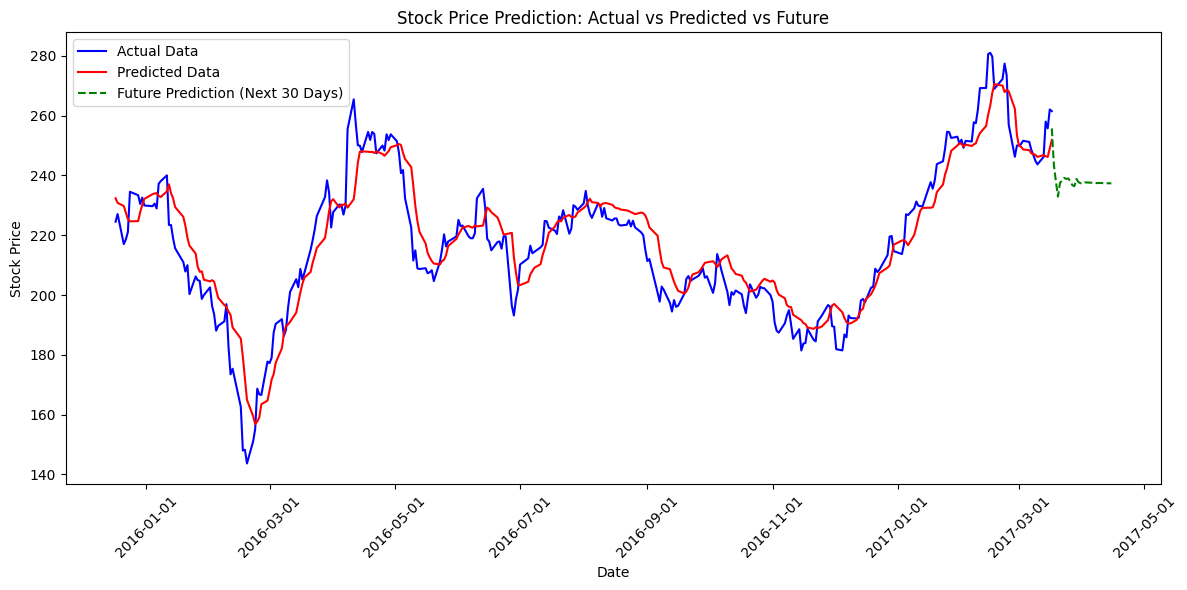

In [ ]:
# -------------------------
# **Prediksi Masa Depan 30 Hari dengan Timestep 9**
# -------------------------

# Gunakan data terakhir dari dataset pengujian sebagai input awal (timestep = 9)
future_input = test_data[-timesteps:, :-1]  # Ambil 9 timestep terakhir sebagai input awal
future_predictions = []

# Loop untuk memprediksi 180 hari ke depan
for _ in range(30):
    # Prediksi hari berikutnya berdasarkan 9 timestep terakhir
    pred = best_model.predict(future_input.reshape(1, timesteps, -1))

    # Simpan hasil prediksi
    future_predictions.append(pred[0, 0])  # Ambil nilai pertama hasil prediksi

    # Perbarui future_input dengan menggantikan data lama
    new_row = np.hstack((future_input[-1, 1:], pred[0]))
    future_input = np.vstack((future_input[1:], new_row))

# Denormalisasi hasil prediksi masa depan
future_predictions = scaler_target.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Buat index tanggal baru untuk prediksi masa depan
last_date = df.index[-1]  # Ambil tanggal terakhir dari dataset
future_dates = pd.date_range(start=last_date, periods=30, freq='D')  # Buat rentang 180 hari ke depan

# Konversi prediksi masa depan ke pandas Series
future_pred_series = pd.Series(future_predictions.ravel(), index=future_dates)

# -------------------------
# **Plot Data Aktual, Prediksi, dan Prediksi Masa Depan**
# -------------------------
plt.figure(figsize=(12, 6))

# Plot data aktual
plt.plot(y_test_denorm_series, label='Actual Data', color='blue')

# Plot hasil prediksi pada data uji
plt.plot(y_test_pred_series, label='Predicted Data', color='red')

# Plot prediksi masa depan
plt.plot(future_pred_series, label='Future Prediction (Next 30 Days)', color='green', linestyle='dashed')

# Judul dan label
plt.title('Stock Price Prediction: Actual vs Predicted vs Future')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)

# Format tanggal agar lebih rapi
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.show()


In [ ]:
from tabulate import tabulate

# Format ulang tanggal agar hanya menampilkan "YYYY-MM-DD"
formatted_dates = [date.strftime('%Y-%m-%d') for date in future_dates]

# Buat daftar tanggal prediksi dan nilai prediksi
data = list(zip(formatted_dates, future_predictions.ravel()))

# Buat header tabel
headers = ['Date', 'Prediction']

# Buat tabel dengan format yang lebih rapi
table = tabulate(data, headers=headers, tablefmt='fancy_grid')

# Cetak tabel
print(table)



╒════════════╤══════════════╕
│ Date       │   Prediction │
╞════════════╪══════════════╡
│ 2017-03-17 │      255.713 │
├────────────┼──────────────┤
│ 2017-03-18 │      243.524 │
├────────────┼──────────────┤
│ 2017-03-19 │      237.886 │
├────────────┼──────────────┤
│ 2017-03-20 │      232.904 │
├────────────┼──────────────┤
│ 2017-03-21 │      237.546 │
├────────────┼──────────────┤
│ 2017-03-22 │      238.261 │
├────────────┼──────────────┤
│ 2017-03-23 │      239.166 │
├────────────┼──────────────┤
│ 2017-03-24 │      238.828 │
├────────────┼──────────────┤
│ 2017-03-25 │      238.979 │
├────────────┼──────────────┤
│ 2017-03-26 │      238.095 │
├────────────┼──────────────┤
│ 2017-03-27 │      236.731 │
├────────────┼──────────────┤
│ 2017-03-28 │      236.386 │
├────────────┼──────────────┤
│ 2017-03-29 │      238.836 │
├────────────┼──────────────┤
│ 2017-03-30 │      237.767 │
├────────────┼──────────────┤
│ 2017-03-31 │      237.383 │
├────────────┼──────────────┤
│ 2017-04-

# Perbandingan BILSTM dan BIGRU

In [ ]:
import pandas as pd

# Membuat DataFrame untuk perbandingan
comparison_df = pd.DataFrame({
    "Metrik": ["MSE", "R-squared", "MAPE (%)", "MAE"],
    "BILSTM": [mseLSTM, r_squaredLSTM, mapeLSTM, maeLSTM],
    "BIGRU": [mseGRU, r_squaredGRU, mapeGRU, maeGRU]
})

# Menampilkan tabel
print(tabulate(comparison_df, headers='keys', tablefmt='grid'))



+----+-----------+----------+-----------+
|    | Metrik    |   BILSTM |     BIGRU |
+====+===========+==========+===========+
|  0 | MSE       | 76.1575  | 69.4211   |
+----+-----------+----------+-----------+
|  1 | R-squared |  0.87767 |  0.888491 |
+----+-----------+----------+-----------+
|  2 | MAPE (%)  |  3.20162 |  3.01344  |
+----+-----------+----------+-----------+
|  3 | MAE       |  6.74637 |  6.38693  |
+----+-----------+----------+-----------+


## Analisis Hasil Evaluasi:
* MSE (Mean Squared Error): BiGRU memiliki nilai MSE yang lebih rendah dibandingkan BiLSTM, menunjukkan bahwa model ini menghasilkan error yang lebih kecil.
*  MAPE (Mean Absolute Percentage Error): BiGRU memiliki MAPE yang lebih rendah, menunjukkan bahwa kesalahan relatif model ini lebih kecil dibandingkan BiLSTM.
*   MAE (Mean Absolute Error): BiGRU memiliki MAE yang lebih kecil, yang berarti model ini menghasilkan prediksi yang lebih akurat secara absolut.
*  R-Squared (R²): BiGRU memiliki nilai R² lebih tinggi, menunjukkan bahwa model ini lebih mampu menjelaskan variasi dalam data dibandingkan BiLSTM.







## Dampak terhadap Business Understanding
Model prediksi harga saham yang dikembangkan memiliki dampak signifikan terhadap pemahaman bisnis, terutama dalam pengambilan keputusan investasi. Berikut adalah beberapa aspek utama dampaknya:



1.  Menjawab Problem Statement dan Mencapai Goals
*  Model yang dikembangkan mampu memprediksi harga saham berdasarkan data historis dengan tingkat akurasi yang baik, membantu investor dalam membuat keputusan lebih tepat.
*  Penggunaan BiLSTM dan BiGRU menunjukkan bahwa deep learning efektif dalam memprediksi harga saham, metrik evaluasi menunjukkan bahwa BiGRU lebih optimal dengan error yang lebih rendah dan nilai R² yang lebih tinggi
* Variabel fitur Open, High, dan Low memiliki pengaruh besar terhadap variabel target Close (mendekati 1) dalam prediksi harga saham. Sementara itu, variabel fitur Volume menunjukkan korelasi yang rendah dengan variabel Close (0,40) yang menunjukkan bahwa perubahan harga tidak selalu berkaitan dengan jumlah volume perdagangan.



2.  Dampak dari Solusi Statement
*   Penggunaan BiLSTM dan BiGRU membuktikan bahwa deep learning dapat menangkap pola harga saham dengan baik, memberikan metode yang lebih canggih dibandingkan pendekatan konvensional.
*   Hasil tuning hyperparameter yang dilakukan berhasil meningkatkan kinerja model secara signifikan, menjadikan model lebih akurat dan andal
*  Model yang dikembangkan dapat menjadi acuan bagi investor dan analis dalam pengambilan keputusan bisnis terkait investasi saham, sehingga dapat meminimalkan risiko dan memaksimalkan keuntungan.









.




## Kesimpulan
Berdasarkan hasil evaluasi, model algoritma BiGRU dipilih sebagai model terbaik untuk memprediksi harga saham. Hal ini didasarkan pada metrik evaluasi yang menunjukkan bahwa BiGRU memiliki error yang lebih rendah (MSE, MAE, dan MAPE) serta nilai R² yang lebih tinggi dibandingkan BiLSTM. Selain itu, BiGRU lebih efisien dalam proses pelatihan dibandingkan BiLSTM, sehingga lebih optimal untuk digunakan dalam peramalan harga saham.

